#### Required Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import scipy as sco
import matplotlib.lines as mlines
import warnings
from datetime import datetime
import sys

warnings.filterwarnings('ignore')

### Data Collecting

In [2]:
# Traditional Asset Classes Study. 1- Local (EM) Equities, 2- Developed Market Equities, 3- Real Estate, 4- Cash (country rates)
# IBOV, IVV (S&P500 + USD/BRL), IFIX, CDI, respectively.

# Defining dates range
start_date = '2004-01-01'
end_date = '2023-10-20'
start_date_br = datetime.strptime(start_date, '%Y-%m-%d').strftime('%d/%m/%Y')
end_date_br = datetime.strptime(end_date, '%Y-%m-%d').strftime('%d/%m/%Y')

# Symbols on YahooFinance
dollar_symbol = 'BRL=X'
sp500_symbol = 'IVV'
ibov_symbol = '^BVSP'

# Simple Returns will be used, mainly because of Asset combinations on portfolio. Solely evaluated, Log-Returns would do better.

# IBOV Data - Yahoo Finance
ibov_data = yf.download(ibov_symbol, start=start_date, end=end_date)

# IFIX Data - Reading local spreadsheet file. Collected w/ Google Sheets & Google Finance. YF doesn't have the data.
ifix_data = pd.read_excel('Historico IFIX 01-01-2013 ate 20-10-2023.xlsx', index_col='Date')
# Filtering. IFIX Start Date: set/2012)
ifix_data = ifix_data[(ifix_data.index >= start_date) & (ifix_data.index <= end_date)]
ifix_data.index = ifix_data.index.normalize()

# IVV Data - S&P500 index variation + USD/BRL exchange.
dollar_data = yf.download(dollar_symbol, start=start_date, end=end_date)
sp500_data = yf.download(sp500_symbol, start=start_date, end=end_date)
# Joining to combine variations
ivv_data = pd.concat([dollar_data['Close'], sp500_data['Close']], axis=1)
ivv_data.columns = ['Dollar', 'SP500']

# CDI Data - Central Bank API. Fetch and returns an interval with daily Selic rates data
url_bcb = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={start_date_br}&dataFinal={end_date_br}'
# url_bcb = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=json&dataInicial={start_date_br}&dataFinal={end_date_br}'
cdi_data = pd.read_json(url_bcb)
cdi_data['data'] = pd.to_datetime(cdi_data['data'], format='%d/%m/%Y')
cdi_data = cdi_data.set_index('data')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Data Processing: Cleaning & Standardization

In [12]:
print(f"Yearly Avg Return and Std Dev for all Indices. \nFrom {start_date} to {end_date}\n\n")

# IBOV Data
ibov_data_daily_pctg = pd.DataFrame(ibov_data['Adj Close'].pct_change().fillna(0)*100)
ibov_avg_return = ibov_data_daily_pctg.mean()*252
ibov_avg_return = ibov_avg_return.rename({'Adj Close': 'IBOV Avg Return'})
ibov_std_dev = ibov_data_daily_pctg.ewm(span=252).std().iloc[-1] * np.sqrt(252)
ibov_std_dev = ibov_std_dev.rename({'Adj Close': 'IBOV Std Dev'})
ibov_stat_data = pd.DataFrame(pd.concat([ibov_avg_return, ibov_std_dev])).transpose()
ibov_data_daily_pctg = ibov_data_daily_pctg.rename(columns={'Adj Close': 'IBOV'})
print(ibov_stat_data.to_string(index=False), "\n")

# IFIX Data
ifix_data_daily_pctg = pd.DataFrame(ifix_data['Close'].pct_change().fillna(0)*100)
ifix_avg_return = ifix_data_daily_pctg.mean()*252
ifix_avg_return = ifix_avg_return.rename({'Close': 'IFIX Avg Return'})
ifix_std_dev = ifix_data_daily_pctg.ewm(span=252).std().iloc[-1] * np.sqrt(252)
ifix_std_dev = ifix_std_dev.rename({'Close': 'IFIX Std Dev'})
ifix_stat_data = pd.DataFrame(pd.concat([ifix_avg_return, ifix_std_dev])).transpose()
ifix_data_daily_pctg = ifix_data_daily_pctg.rename(columns={'Close': 'IFIX'})
print(ifix_stat_data.to_string(index=False), "\n")

# IVV Data
ivv_data_daily_pctg = pd.DataFrame(ivv_data.pct_change().fillna(0)*100)
ivv_data_daily_pctg['IVV'] =  ivv_data_daily_pctg['Dollar'] + ivv_data_daily_pctg['SP500'] # Adding up variations
ivv_data_daily_pctg.drop(ivv_data_daily_pctg[['Dollar', 'SP500']], axis=1)
ivv_avg_return = ivv_data_daily_pctg.mean()*252
ivv_avg_return = ivv_avg_return.rename({'Dollar': 'Dollar Avg Return', 'SP500': 'SP500 Avg Return', 'IVV': 'IVV Avg Return'})
ivv_std_dev = ivv_data_daily_pctg.ewm(span=252).std().iloc[-1] * np.sqrt(252)
ivv_std_dev = ivv_std_dev.rename({'Dollar': 'Dollar Std Dev', 'SP500': 'SP500 Std Dev', 'IVV': 'IVV Std Dev'})
ivv_stat_data = pd.DataFrame(pd.concat([ivv_avg_return, ivv_std_dev])).transpose()
print(ivv_stat_data[['IVV Avg Return', 'IVV Std Dev']].to_string(index=False), "\n")
# print(ivv_stat_data.to_string(index=False), "\n")


# CDI Data
cdi_data_daily_pctg = cdi_data
cdi_avg_return = cdi_data_daily_pctg.mean()*252
cdi_avg_return = cdi_avg_return.rename({'valor': 'CDI Avg Return'})
cdi_std_dev = cdi_data_daily_pctg.std()*252
cdi_std_dev = cdi_std_dev.rename({'valor': 'CDI Std Dev'})
cdi_stat_data = pd.DataFrame(pd.concat([cdi_avg_return, cdi_std_dev])).transpose()
cdi_data_daily_pctg = cdi_data_daily_pctg.rename(columns={'valor': 'CDI'})
print(cdi_stat_data.to_string(index=False), "\n")

# Consolidated daily variation for all indices
consolidated_variation = pd.concat([ibov_data_daily_pctg,
                                    pd.DataFrame(ivv_data_daily_pctg['IVV']), 
                                    ifix_data_daily_pctg,
                                    cdi_data_daily_pctg],
                                    axis=1).fillna(0)

Yearly Avg Return and Std Dev for all Indices. 
From 2004-01-01 to 2023-10-20


 IBOV Avg Return  IBOV Std Dev
       12.062644     18.079011 

 IFIX Avg Return  IFIX Std Dev
        6.912262      4.891274 

 IVV Avg Return  IVV Std Dev
      12.840194    19.110095 

 CDI Avg Return  CDI Std Dev
      10.221012     3.725367 



### Correlation Matrix

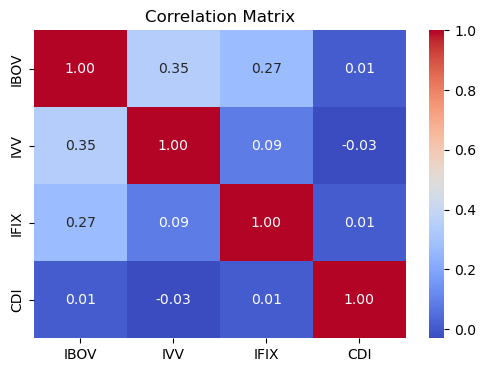

In [4]:
correlation_matrix = consolidated_variation.corr()

# Seaborn map
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')  
plt.show()

# Covariance Matrix
consolidated_variation_cov = consolidated_variation.cov()

In [5]:
print("Average Return")
avg_return_consolidated = consolidated_variation.mean()*252
print(avg_return_consolidated)

Average Return
IBOV    11.448299
IVV     12.802897
IFIX     3.577939
CDI      9.844948
dtype: float64


In [6]:
print("Standard Deviation")
std_dev_consolidated = consolidated_variation.ewm(span=252).std().iloc[-1] * np.sqrt(252)
print(std_dev_consolidated)
# CDI got different
print("---------------------")
print("CDI Standard Deviation (Another Form):", consolidated_variation['CDI'].std()*252)

Standard Deviation
IBOV    17.544850
IVV     19.034431
IFIX     4.745678
CDI      0.165227
Name: 2023-10-20 00:00:00, dtype: float64
---------------------
CDI Standard Deviation (Another Form): 4.131667463078195


In [7]:
# Portfolio Generation
n_portfolios = 4000

p_ret=[]
p_vol=[]
p_pesos=[]

n_ativos=len(consolidated_variation.columns) # Quantidade de ativos

for portfolios in range(n_portfolios):
    pesos=np.random.random(n_ativos) # Pesos aleatórios
    pesos=pesos/np.sum(pesos) # Pesos que somam 1
    p_pesos.append(pesos)
    
    returns=np.dot(pesos, consolidated_variation.mean()*252) # Retornos
    p_ret.append(returns)
    
    var=consolidated_variation_cov.mul(pesos, axis=0).mul(pesos, axis=1).sum().sum() # Covariância
    dp=np.sqrt(var) # Desvio-Padrão
    p_vol.append(dp)

p_ret=np.array(p_ret)
p_vol=np.array(p_vol)
dados={'Return': p_ret, 'Std Dev': p_vol}
portfolios=pd.DataFrame(dados)
portfolios

,Return,Std Dev
0,9.941607,0.720146
1,9.684164,0.988727
2,10.611038,0.806178
3,10.870321,0.771670
4,9.769965,0.592086
...,...,...
3995,11.253163,0.749740
3996,9.203639,0.746664
3997,9.669396,0.756754
3998,8.106454,0.285821


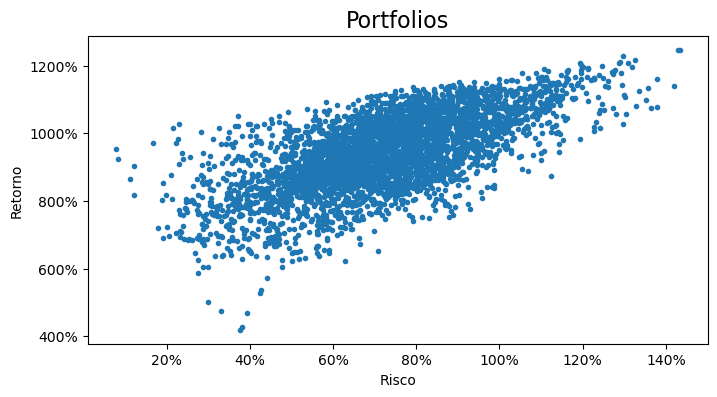

In [8]:
# Gráfico de Portfolios
plt.figure(figsize=(8,4))
plt.scatter(portfolios['Std Dev'], portfolios['Return'], marker='.')
plt.title('Portfolios', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

In [9]:
def my_function():
    """
        Docstring. Primeira linha resumo da funcionalidade

        Params: explicar cada parâmetro. separar a explicação de cada um deles em uma linha específica

        Return: Se tiver um retorno, escrever sobre o retorno. Se tiver raise de exceções, 
    """

